![logo](../../LogoLine_horizon_C3S.png)

<div class="alert alert-block alert-warning">
Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch
</div>

# Detecting and Attributing Climate Change Impacts on Global Lake Ice Depth and Mixed-Layer Temperature

Production date: 29-09-2025

Produced by: Amaya Camila Trigoso Barrientos (VUB)

## 🌍 Use case: Reference product for climate change detection and attribution

## ❓ Quality assessment question
* **Can ERA5-Land be used as a reference product in place of observations for climate change detection and atribution of lake ice and temperature changes on a global scale?**

Lakes worldwide are experiencing changes in ice cover and water temperature. Climate change impacts detection and attribution of these changes require long-term, consistent, and spatially extensive datasets, yet direct observations remain sparse, discontinuous, or limited to recent decades. Reanalysis products such as ERA5-Land provide an alternative, offering global coverage at high spatial and temporal resolution and showing strong agreement with in situ and satellite observations. This quality assessment draws on the study by Grant et al. (2021) *Attribution of global lake systems change to anthropogenic forcing* (Nat. Geosci., 14, 849–854)[[1]](https://doi.org/10.1038/s41561-021-00833-x), reviewing specifically the parts where ERA5-Land was used as a reference for historical detection and attribution (excluding future projections). The aim is to assess whether ERA5-Land can reliably serve as a substitute for direct observations in global-scale detection and attribution of climate-driven changes in lake ice and mixed-layer temperature.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* ERA5-Land provides long, continuous, and high-resolution global records that have been validated against in situ and satellite datasets, showing strong agreement for both lake temperature and ice phenology.
* These characteristics make ERA5-Land a suitable reference product for detection and attribution of climate change impacts on lakes globally, especially where direct observations are sparse or discontinuous.

## 📋 Methodology

The relevant results to this assessment from Grant et al. (2021) [[1]](https://doi.org/10.1038/s41561-021-00833-x) are presented to highlight the role of ERA5-Land in detection and attribution. First, changes in lake mixed-layer temperature and ice depth from ERA5-Land are shown by comparing a recent period (2010-2019) with a baseline (1981-1990). These changes represent key observations with implications for ecosystems, local weather, and climate impacts. To formally detect the influence of climate change, two approaches were applied: (i) Spearman rank correlation coefficients apporach, and (ii) regularized optimal fingerprinting (ROF), which provides both detection and attribution. Finally, the high temporal and spatial resolution of ERA5-Land is discussed as an important factor supporting its suitability as a reference dataset in attribution studies.

**[](reanalysis_reanalysis-era5-land-monthly-means_completeness_q03:section-1)**
 * Download lake mixed-layer temperature and lake ice depth from ERA5-Land monthly for the periods 2010-2019 and 1981-1990.
 * Change in lake mixed-layer temperature from ERA5-Land in the recent period 2010-2019 compared to the baseline period 1981-1990. 
 * Changes in ice onset, break-up and duration derived from ERA5-Land lake ice depth in the recent period 2010-2019 compared to the baseline period 1981-1990.

**[](reanalysis_reanalysis-era5-land-monthly-means_completeness_q03:section-2)**
 * Detection of climate change impacts using Spearman rank correlation coefficients.
 * Detection and attribution using ROF.

**[](reanalysis_reanalysis-era5-land-monthly-means_completeness_q03:section-3)**
 * Review ERA5-Land's temporal and spatial completeness and its usefulness as a reference product.

## 📈 Analysis and results

(reanalysis_reanalysis-era5-land-monthly-means_completeness_q03:section-1)=
### 1. Reanalyzed changes in lake ice and temperature

Grant et al. (2021) observed that the lake mixed-layer temperature from ERA5-Land in the recent period 2010-2019 compared to the baseline period 1981-1990 had an average global increase of 0.4 °C [[1]](https://doi.org/10.1038/s41561-021-00833-x). 

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
import os
import io
import pickle
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import pymannkendall as mk
import shapely
import shapely.geometry
import xarray as xr
import tempfile
import zipfile
import rioxarray
from c3s_eqc_automatic_quality_control import diagnostics, download, plot

In [2]:
collection_id = "reanalysis-era5-land-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": [
        "lake_ice_depth",
        "lake_mix_layer_temperature"
    ],
    "year": [
        "1981", "1982",
        "1983", "1984", "1985",
        "1986", "1987", "1988",
        "1989", "1990",
        "2010", "2011", "2012",
        "2013", "2014", "2015",
        "2016", "2017", "2018",
        "2019"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "grib",
    "download_format": "zip"
}

In [3]:
ds = download.download_and_transform(collection_id, request, chunks={"year": 1})

100%|██████████| 20/20 [00:02<00:00,  7.80it/s]
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'u

In [4]:
# Shift longitude from 0–360 → -180–180
ds_shifted = ds.assign_coords(
    longitude=(((ds.longitude + 180) % 360) - 180)
).sortby("longitude")

# Now work with this shifted dataset
da_lmlt = ds_shifted["lmlt"]

In [5]:
# Define baseline and recent periods
baseline_lmlt = da_lmlt.sel(forecast_reference_time=slice("1981-01-01", "1990-12-31"))
recent_lmlt   = da_lmlt.sel(forecast_reference_time=slice("2010-01-01", "2019-12-31"))

# Compute climatological seasonal means for each period
baseline_seasonal_lmlt = baseline_lmlt.groupby("forecast_reference_time.season").mean("forecast_reference_time")
recent_seasonal_lmlt   = recent_lmlt.groupby("forecast_reference_time.season").mean("forecast_reference_time")

# Difference (recent - baseline)
diff_lmlt = recent_seasonal_lmlt - baseline_seasonal_lmlt

# Order seasons
seasons_lmlt = ["DJF", "MAM", "JJA", "SON"]

In [6]:
url = "https://github.com/VUB-HYDR/2021_Grant_etal/raw/refs/heads/master/python/part1/data/mlt/era5-land_lakes_mixlayertemp_DJF_signal_1981_2019.nc"
local_path = "era5_land_lakes.nc"

# Download and save
r = requests.get(url)
r.raise_for_status()
with open(local_path, "wb") as f:
    f.write(r.content)

# Open with netcdf4 engine
ds_paper = xr.open_dataset(local_path, engine="netcdf4", decode_times=False)

In [7]:
# Shift longitude from 0–360 → -180–180
ds_paper_shifted = ds_paper.assign_coords(
    longitude=(((ds_paper.longitude + 180) % 360) - 180)
).sortby("longitude")

# Now work with this shifted dataset
ds_paper_shifted_lmlt = ds_paper_shifted["lmlt"]

In [8]:
paper_data = ds_paper_shifted_lmlt.isel(time=0)  # first time step

mask_aligned = (~np.isnan(paper_data)).reindex(
    latitude=diff_lmlt.latitude,
    longitude=diff_lmlt.longitude,
    method="nearest"
)

masked_data = diff_lmlt.where(mask_aligned)

/data/wp5/.tmp/ipykernel_316472/2513860882.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


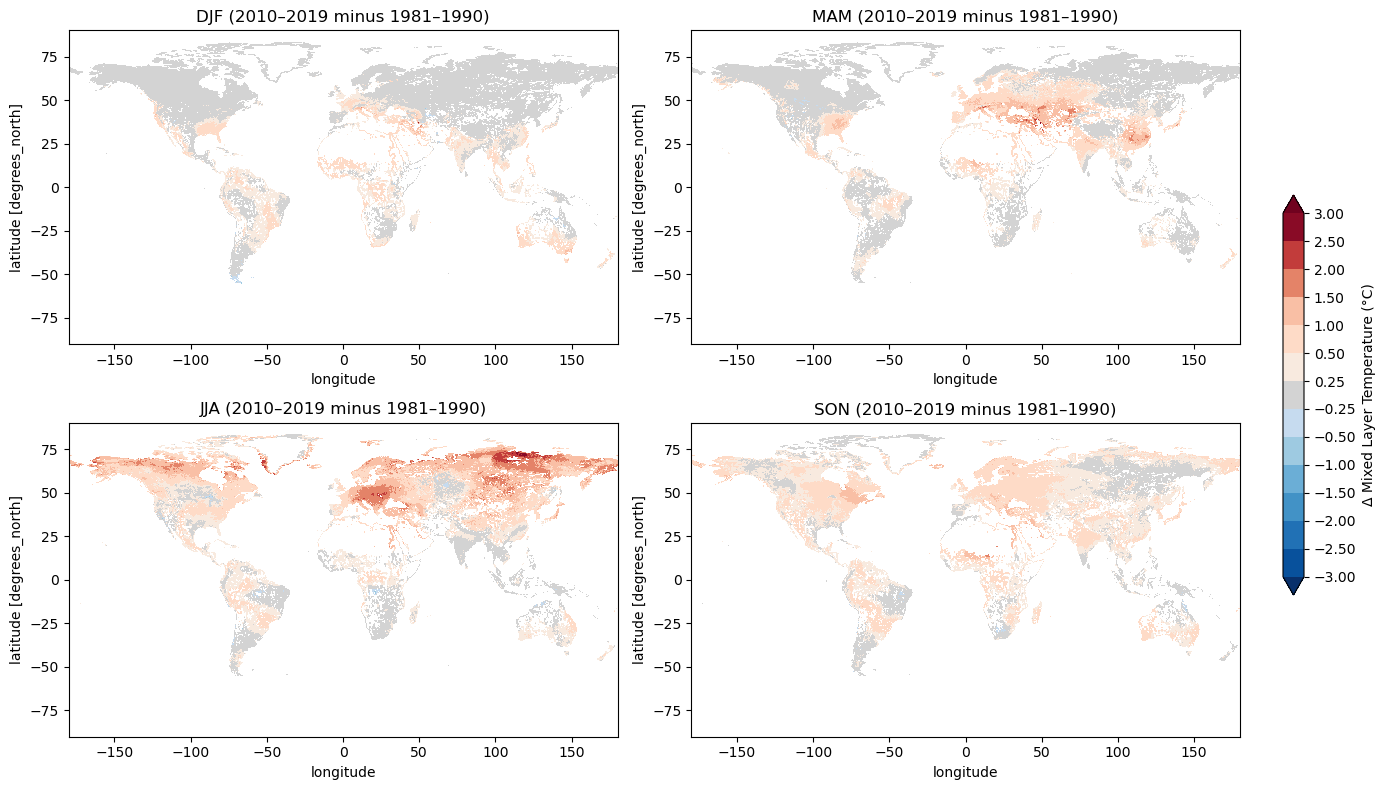

In [9]:
# Define boundaries (14 boundaries = 13 bins)
levels = [-3, -2.5, -2, -1.5, -1, -0.5, -0.25, 0.25, 0.5, 1, 1.5, 2, 2.5, 3]

# Define colors (15 colors for 15 bins including extensions)
colors = [
    "#08306b",  # < -3 (extra darkest blue)
    "#08519c", "#2171b5", "#4292c6", "#6baed6", "#9ecae1", "#c6dbef", # -2.5 to -0.25
    "lightgray",                                                # -0.25 to 0.25
    "#f8eadf", "#fedbc7", "#f9bfa5", "#e48368", "#c23c3b", "#890b26",  # 0.25 to 3
    "#70021f"   # > 3 (extra darkest red)
]

# Make colormap
cmap = mcolors.ListedColormap(colors)
cmap.set_bad("white")  # NaN = white

# BoundaryNorm with extension
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, extend="both")

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for ax, season in zip(axes.flat, seasons_lmlt):
    im = masked_data.sel(season=season).plot(
        ax=ax,
        cmap=cmap,
        norm=norm,
        add_colorbar=False
    )
    ax.set_title(f"{season} (2010–2019 minus 1981–1990)")

# Shared colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax, extend="both", boundaries=levels, ticks=levels)
cbar.set_label("Δ Mixed Layer Temperature (°C)")

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

*Figure 1: Change in lake mixed layer from ERA5-Land in 40 years across baseline (1981-1990) and recent (2010-2019) periods. Replicated from:  Grant et al. (2021) [[1]](https://doi.org/10.1038/s41561-021-00833-x) (Supplementary information)*

In [12]:
spatial_mean = diagnostics.spatial_weighted_mean(masked_data)

In [21]:
# temporal mean (lazy dask object)
avg_temporal = spatial_mean.mean(dim="season")

# actually compute it
avg_temporal_value = avg_temporal.compute()

print("Average Δ Mixed Layer Temperature = ", round(avg_temporal_value.item(),2)," °C")

Average Δ Mixed Layer Temperature =  0.39  °C


The lake ice depth variable from ERA5-Land was used to calculate homogenized ice onset, break-up and duration values. The difference between the same baseline and recent periods were computed showing that 130,472 lake grid cells have experienced two weeks of lake ice-loss. On average, lakes lost 9 days of ice-cover according to this analysis.

![fig1.jpg](bdc11b65-c247-48cb-bfcf-6aadbfc0a246.jpg)

*Figure 2: a–c, Changes (Δ) in ice onset (a), ice break-up (b) and ice duration (c) in 40 years across baseline (1981–1990) and recent (2010–2019) periods as obtained from ERA5-Land. Source: Grant et al. (2021) [[1]](https://doi.org/10.1038/s41561-021-00833-x)*

The variables lake ice depth and lake mix layer temperature from ERA5-Land were employed by Grant et al. (2021) as a reference product and substitute for observations. It was used as a reference for detection and attribution of climate change impacts.

(reanalysis_reanalysis-era5-land-monthly-means_completeness_q03:section-2)=
### 2. Climate change detection and attribution

Global sacale simulations were performed with 5 lake models each forced by 4 global climate models (GSMs). The forcings were carried out under historical (HIST) and a collection of induvidual pre-industrial control (PIC) scenarios.

To perform the detection of climate change impacts, the annual global average of the simulation outputs were computed and them anomalies computed. The same was done for the reference reanalisis product. This was used to perfor detection by two approaches: correlation and regularized optimal fingerprinting (ROF). 

Spearman rank correlation coefficients were calculated between chunks of PIC and HIST simulations. A probability density function (PDF) of these coefficients was derived under the assumption of a normal distribution, and 95% and 99% confidence intervals were estimated. This distribution represents the correlations expected under pre-industrial climate variability. In addition, the Spearman correlation was also calculated between HIST and ERA5-Land. These results are shown in Figure 3a–d and demonstrate that the HIST vs. ERA5-Land correlations for all variables are not consistent with what would be expected from pre-industrial climate variability. The HIST vs. ERA5-Land probability density is much higher than what would be expected according to the PIC vs. HIST distribution, for the correlation coefficients respective to HIST vs. ERA5-Land. These correlation coefficients exceed the 99% confidence level in case of water temperature, ice break-up and ice duration, and lie above the 95% confidence level for ice onset.

Figure 3e–h show the anomalies for the different variables over the years. Also, as insets in the subfigures is the single-factor ROF output of comparing HIST to ERA5-Land. If this factor does not everlap with 0, ROF communicates detection. Moreover, if the factor overlaps with 1, "ROF attributes the changes in a given lake variable to all external forcings, revealing that a lake variable’s trend can be explained by historical climate forcings dominated by anthropogenic climate change" [[1]](https://doi.org/10.1038/s41561-021-00833-x). Therefore, ROF communicates detection of climate change impacts for all variables studied and atribution for lake ice depth related variables, but not for water temperature.

![fig2.jpg](acb63262-e234-4733-90e5-f44661266286.jpg)

*Figure 3: a–d, Empirical distribution of correlation coefficients between PIC and HIST for lake temperature (a), ice onset (b), ice break-up (c) and ice duration (d). Red lines show the correlation coefficient between HIST and ERA5-Land. Vertical blue lines mark the 95% and 99% cumulative probability of an assumed normal distribution for the sample of PIC–HIST coefficients. e–h, Global multimodel mean time series and spread (ensemble standard deviation) for PIC and HIST forced response patterns and ERA5-Land smoothed by a 5 yr running mean for lake temperature (e), ice onset (f), ice break-up (g) and ice duration (h). Results of single-factor ROF output on HIST are displayed in insets. Scaling factor confidence intervals denote their 2.5–97.5% uncertainty range and infer detection when excluding the 0 line. Attribution is achieved when confidence intervals additionally include unity. Source: Grant et al. (2021) [[1]](https://doi.org/10.1038/s41561-021-00833-x)*

Water temperature changes were not formally attributed, as Figure 3e shows that the HIST simulations consistently overestimate anomalies compared with the ERA5-Land reference. Since ERA5-Land has been evaluated against observations and shown strong agreement, the discrepancy is more likely due to issues within the ISIMIP lake simulations. Grant et al. (2021) [[1]](https://doi.org/10.1038/s41561-021-00833-x) identified these three factors presented in the supplementary information section:
* Lake depth fields: Both ERA5-Land and ISIMIP use the Global Lake Depth Database (GLDB), but ERA5-Land relies on version 3, which contains more accurate and extensive information, while ISIMIP employs version 1,
* Water transparency: ERA5-Land applies a fixed light extinction coefficient of 3, representing turbid brown water, whereas ISIMIP parameterizations vary by lake depth or, in one case, particulate organic matter.
* ISIMIP meteorological forcing: Although corrected for long-term statistics of observations, the atmospheric variables are not corrected for potential biases in trends.

(reanalysis_reanalysis-era5-land-monthly-means_completeness_q03:section-3)=
### 3. Suitability of ERA5-Land

ERA5-Land provides global coverage from January 1950 to the present at hourly resolution and is updated daily. Its finer spatial resolution (0.1°, ~9 km) offers more detailed representation of local climate than coarser reanalyses such as ERA5, making it particularly suitable for lake studies. These characteristics make ERA5-Land a valid reference product for detection and attribution studies, which require sufficiently long time periods for the climate signal to emerge clearly above annual and decadal variability [[1]](https://doi.org/10.1038/s41561-021-00833-x). In contrast, satellite products are limited to more recent decades and contain some temporal gaps, for example due to cloud and water vapor interference. Because of these temporal limitations and discontinuities in satellite records, ERA5-Land offers a more consistent and extended dataset and is therefore a strong candidate for use as the reference in attribution analyses.

## ℹ️ If you want to know more

* J. Muñoz-Sabater, Dutra, E., Agustí-Panareda, A., Albergel, C., Arduini, G., Balsamo, G., Boussetta, S., Choulga, M., Harrigan, S., Hersbach, H., Martens, B., Miralles, D. G., Piles, M., Rodríguez-Fernández, N. J., Zsoter, E., Buontempo, C., & Thépaut, J.-N. (2021) ERA5-Land: A state-of-the-art global reanalysis dataset for land applications, Earth Syst. Sci. Data,13, 4349–4383. [](https://doi.org/10.5194/essd-13-4349-2021).
* Bindoff, N.L., P.A. Stott, K.M. AchutaRao, M.R. Allen, N. Gillett, D. Gutzler, K. Hansingo, G. Hegerl, Y. Hu, S. Jain, I.I.
Mokhov, J. Overland, J. Perlwitz, R. Sebbari & X. Zhang. (2013) Detection and Attribution of Climate Change:
from Global to Regional. In: Climate Change 2013: The Physical Science Basis. Contribution of Working Group
I to the Fifth Assessment Report of the Intergovernmental Panel on Climate Change Stocker, T.F., D. Qin, G.-K.
Plattner, M. Tignor, S.K. Allen, J. Boschung, A. Nauels, Y. Xia, V. Bex and P.M. Midgley (eds.). Cambridge University
Press, Cambridge, United Kingdom and New York, NY, USA. [](https://www.ipcc.ch/site/assets/uploads/2018/02/WG1AR5_Chapter10_FINAL.pdf).

### Key resources

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

### References

[[1]](https://doi.org/10.1038/s41561-021-00833-x) Grant, L., Vanderkelen, I., Gudmundsson, L., Tan, Z., Perroud, M., Stepanenko, V. M., Debolskiy, A. V., Droppers, B., Janssen, A. B. G., Woolway, R. I., Choulga, M., Balsamo, G., Kirillin, G., Schewe, J., Zhao, F., Vega del Valle, I., Golub, M., Pierson, D., Marcé, R., Seneviratne, S. I., & Thiery, W. (2021) Attribution of global lake systems change to anthropogenic forcing. Nat. Geosci. 14, 849–854.